In [51]:
import re, string,os
from glob import glob as gb
import pandas as pd
from tqdm import tqdm
from collections import Counter
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import matplotlib
from functions import *
import calendar
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from datetime import datetime
import matplotlib.dates as mdates
import spacy
nlp = spacy.load('en_core_web_sm')

from nltk.corpus import stopwords

base_path = "/home/ruben/Documents/GitHub/ParlaMintCase"

In [2]:
tf = pd.read_csv(base_path + '/resources/keywords-expertise-translation.csv')
tf_science = {language:dict(zip(tf[tf['language'] == language]['word'],tf[tf['language'] == language]['translation'])) for language in list(set(tf['language']))}
tf_science = {k:{x:i for x,i in v.items() if x not in ["policy","program","measures","knowledge","information"]} for k,v in tf_science.items()}
tf_science.update({"gb":{k:k for k,v in tf_science['nl'].items()}})

In [55]:
df = data_loader.period(language="gb",data_version="lemmatized",start_date="2020-01",end_date="2020-05")
df = df[df['id'].astype(str).str.len() > 2].dropna().reset_index(drop=True)
df['date'] = [utils.find_date(x)[:10] for x in df['id']]
# df['date'] = [datetime.strptime(x, '%Y-%m-%d') for x in df['date']]
# df['date'] = [str(x.year) + "-" + str(x.isocalendar()[1]) for x in df['date']]
# df['date'] = [x.replace('-','-0') if len(x) == 6 else x for x in df['date']]
df = df[df.id.astype(str).str.contains('-commons')]
df = utils.add_metadata(df,'gb')
df['text'] = utils.preprocess_(df['text'],stopwords=set(stopwords.words('english')) | set("hon. friend right gentleman people government hon member".split(' ')))
df['text'] = [re.sub(r'[^A-Za-z0-9 ]+', '', str(s)) for s in df['text']]

found 98 files
  3%|▎         | 897/28832 [00:25<12:02, 38.68it/s]

In [56]:
df['text'] = [" ".join([w.lemma_ for w in nlp(t) if w.pos_ in ["NOUN","ADJ"]]) for t in tqdm(df['text'])]


100%|██████████| 18874/18874 [04:27<00:00, 70.52it/s]


In [57]:
# df = df[df.text.str.contains("virus|pandemic|epidemic|covid|sars")]
# df['l'] = ["science" if any(n in t for n in tf_science['gb'].values()) == True else "other" for t in df['text']]
df['l'] = ["covid" if any(n in t for n in ["virus","pandemic","epidemic","covid","sars-cov2"]) == True else "other" for t in df['text']]

df = df[df['l'] == 'covid'].reset_index(drop=True)
df = pd.DataFrame([[d," ".join(list(df[df['date'] == d]['text']))] for d in set(df['date'])],columns=['date','text']).sort_values('date')

In [58]:
# Top Terms
r = pd.DataFrame()
tfidf_obj,docterms = tfidf.get_docterms(df,'text')
for day in tqdm(sorted(list(set(df['date'])))):
    df['dl'] = ["day" if date_ == day else "other" for date_ in df['date']]
    tftw = tfidf.get_topterms(tfidf_obj,docterms,df,'dl')
    r[day] = tftw['day'][:15]
# r.to_csv(os.path.join(base_path,"results/gb-topterms-tfidf.csv"),index=False)


100%|██████████| 38/38 [00:01<00:00, 19.22it/s]


In [59]:
dates = sorted(list(r.columns))
names = ["\n".join(list(r[d][:5])) for d in dates]
dates = [datetime.strptime(d, "%Y-%m-%d") for d in dates]

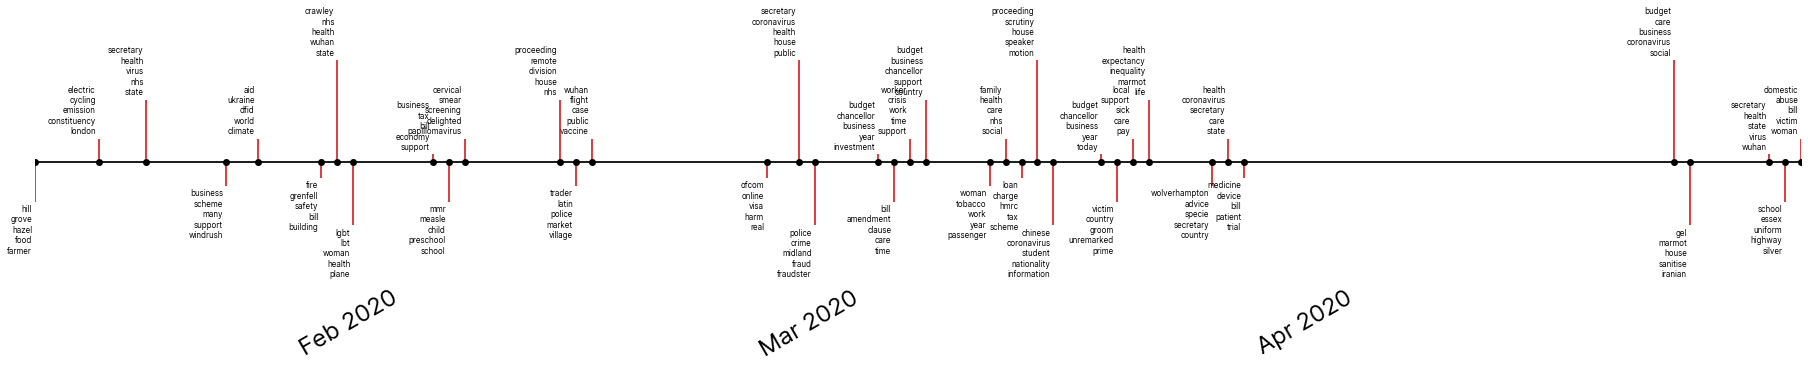

In [60]:
# Styling
sns.set(font='Inter, Medium')
sns.set_palette('viridis')
sns.set(font='Inter, Medium',rc={'axes.xmargin':0,'axes.ymargin':0,'axes.axisbelow': True,'axes.edgecolor': 'lightgrey','axes.facecolor': 'None', 'axes.grid': False,'axes.labelcolor':'black','axes.spines.top': True,'figure.facecolor': 'white','lines.solid_capstyle': 'round','patch.edgecolor': 'w','patch.force_edgecolor': True,'text.color': 'black','xtick.bottom': True,'xtick.color': 'black','xtick.direction': 'out','xtick.top': False,'ytick.color': 'black','ytick.direction': 'out','ytick.left': False, 'ytick.right': False})

levels = np.tile([-5, 3, 8, -3, 3, -2, 13, -8, 1],int(np.ceil(len(dates)/8)))[:len(dates)]

# Create figure and plot a stem plot with the date
fig, ax = plt.subplots(figsize=(25, 5), constrained_layout=True)

ax.vlines(dates, 0, levels, color="tab:red")  # The vertical stems.
ax.plot(dates, np.zeros_like(dates), "-o",
        color="k", markerfacecolor="black")  # Baseline and markers on it.

# annotate lines
for d, l, r in zip(dates, levels, names):
    ax.annotate(r, xy=(d, l),
                xytext=(-3, np.sign(l)*3), textcoords="offset points",
                horizontalalignment="right",
                verticalalignment="bottom" if l > 0 else "top",
                fontsize=8)

# format xaxis with 4 month intervals
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter("%b %Y"))
plt.setp(ax.get_xticklabels(), rotation=30, ha="right",fontsize=24)

# remove y axis and spines
ax.yaxis.set_visible(False)
# ax.spines[["left", "top", "right"]].set_visible(False)

ax.margins(y=0.1)
plt.ylim(-15,15)
plt.show()